In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Data Loading

In [ ]:
df = pd.read_csv('../../dataset/data_assemble_new.csv')
for idx, row in df.iterrows():
  if df.loc[idx, 'Speaker'].split('_')[-1][0] == df.loc[idx, 'Session'].split('_')[1]:
    df.loc[idx, 'Position'] = 'Speaker'
  elif df.loc[idx, 'Year'] == 20:
    df.loc[idx, 'Position'] = 'Speaker'
  else:
    df.loc[idx, 'Position'] = 'Listener'

In [ ]:
df_speaker = df.loc[df['Position'] == 'Speaker', :]
df_speaker

,Wav_start,Wav_end,Speaker,Emotion,Valence,Arousal,IBI_mean,IBI_count,IBI_std,IBI_max,...,TEMP_max,TEMP_min,TEMP_range,TEMP_difference,Emotion_p_i,Fleiss_Kappa,Session,Wav_length,Year,Position
1,15.47600,19.786,Sess01_script01_F001,fear,1.5,3.6,0.940800,5.0,0.022163,0.960000,...,30.71,30.69,0.02,0.02,0.488889,0.194631,Session01_F_res,4.31000,19,Speaker
4,28.94300,32.167,Sess01_script01_F002,fear,1.6,3.7,0.916000,3.0,0.024331,0.944000,...,30.71,30.69,0.02,0.02,0.644444,0.198791,Session01_F_res,3.22400,19,Speaker
6,39.26400,46.833,Sess01_script01_F003,fear,1.4,4.1,0.828889,9.0,0.026816,0.868000,...,30.75,30.69,0.06,0.04,0.355556,0.198791,Session01_F_res,7.56900,19,Speaker
9,64.02400,65.189,Sess01_script01_F004,angry,1.5,4.0,0.848000,1.0,NaN,0.848000,...,30.71,30.69,0.02,0.02,0.288889,0.189189,Session01_F_res,1.16500,19,Speaker
11,73.01600,83.209,Sess01_script01_F005,fear,1.5,3.5,0.804923,13.0,0.054262,0.872000,...,30.73,30.71,0.02,0.02,0.533333,0.070443,Session01_F_res,10.19300,19,Speaker
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34023,289.44998,294.943,Sess40_script06_User079F_043,neutral,3.0,3.5,0.801339,7.0,0.032167,0.843750,...,35.07,35.05,0.02,-0.02,1.000000,0.259259,Sess40_eval,5.49302,20,Speaker
34024,294.94300,297.598,Sess40_script06_User079F_044,neutral,2.9,3.1,0.760417,3.0,0.018042,0.781250,...,35.07,35.05,0.02,0.02,1.000000,-0.045752,Sess40_eval,2.65500,20,Speaker
34025,297.59800,304.171,Sess40_script06_User079F_045,neutral,2.6,3.6,0.789931,9.0,0.036736,0.828125,...,35.07,35.05,0.02,0.00,0.800000,0.139785,Sess40_eval,6.57300,20,Speaker
34026,304.17100,306.863,Sess40_script06_User079F_046,neutral,2.7,3.3,0.755208,3.0,0.009021,0.765625,...,35.07,35.05,0.02,0.02,0.622222,-0.003584,Sess40_eval,2.69200,20,Speaker


In [ ]:
df_speaker = df_speaker[df_speaker['Emotion'].str.contains(';')==False]
df_speaker['Emotion'] = df_speaker['Emotion'].apply(lambda x: "disgust" if x == "disqust" else x) # disqust 감정 disgust와 합침

<ipython-input-108-12ad376ecb61>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_speaker['Emotion'] = df_speaker['Emotion'].apply(lambda x: "disgust" if x == "disqust" else x) # disqust 감정 disgust와 합침


### Data Preprocessing

In [ ]:
df_notnull = df_speaker.dropna()
df_notnull.reset_index(drop=True, inplace=True)

이상치 걸러내는 함수

In [ ]:
def outlier_removal(df, col_name, outlier_policy):

  Q1 = df[col_name].quantile(0.25)
  Q3 = df[col_name].quantile(0.75)
  IQR = Q3 - Q1

  lower_bound = Q1 - outlier_policy * IQR
  upper_bound = Q3 + outlier_policy * IQR

  non_outliers = df[(df[col_name] > lower_bound) & (df[col_name] < upper_bound)]

  return non_outliers


이상치 제거 전후 비교교

In [ ]:
def compare_outlier_graph(before_df, after_df, col_name):

  fig, axs = plt.subplots(1, 2, figsize=(10, 5))

  axs[0].set_title(f'Before {col_name} outlier removal')
  axs[0].hist(before_df[col_name], bins=100)

  axs[1].set_title(f'After {col_name} outlier removal')
  axs[1].hist(after_df[col_name], bins=100)

  plt.show()

### 이상치 걸러내기

IBI

(15947, 33)


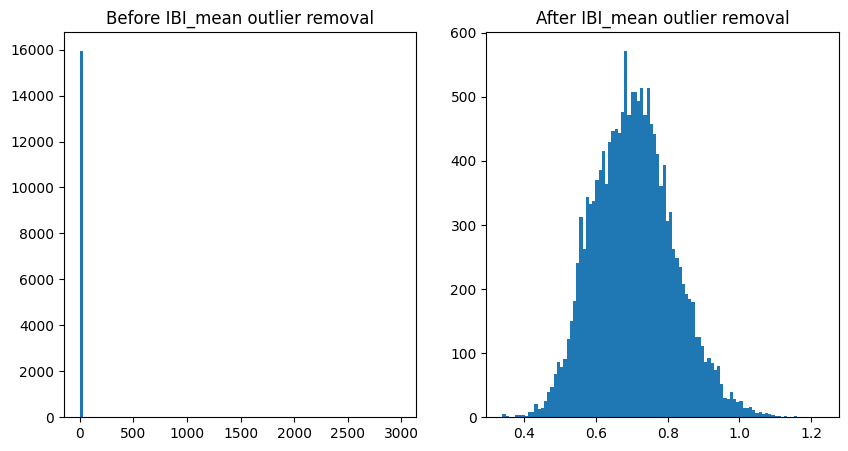

In [ ]:
ibi_mean = outlier_removal(df_notnull, 'IBI_mean', 3)
print(ibi_mean.shape)
compare_outlier_graph(df_notnull, ibi_mean, 'IBI_mean')

(15931, 33)


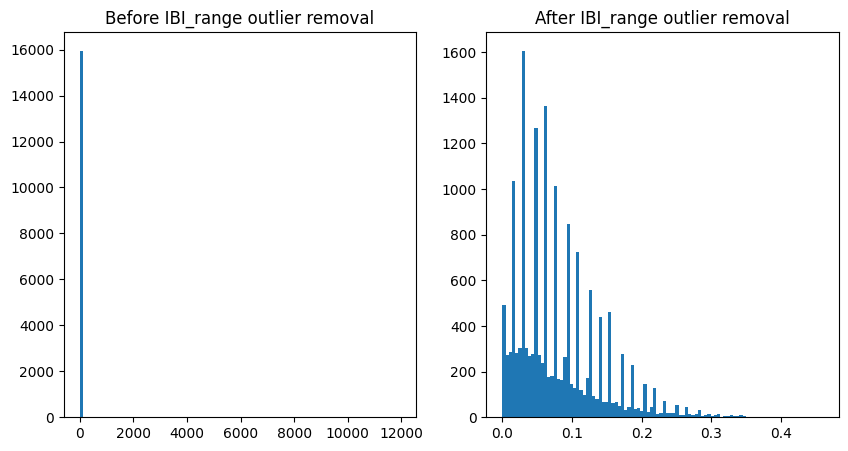

In [ ]:
ibi_range = outlier_removal(df_notnull, 'IBI_range', 5)
print(ibi_range.shape)
compare_outlier_graph(df_notnull, ibi_range, 'IBI_range')

(15943, 33)


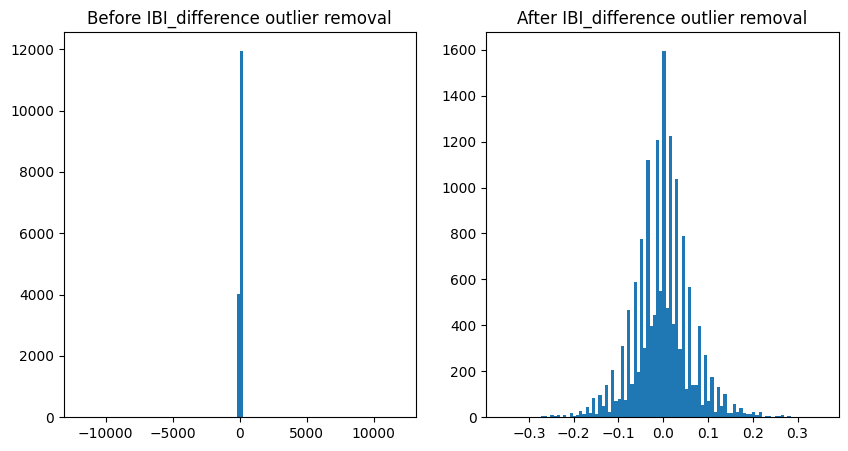

In [ ]:
ibi_difference = outlier_removal(df_notnull, 'IBI_difference', 5)
print(ibi_difference.shape)
compare_outlier_graph(df_notnull, ibi_difference, 'IBI_difference')

EDA

(15862, 33)


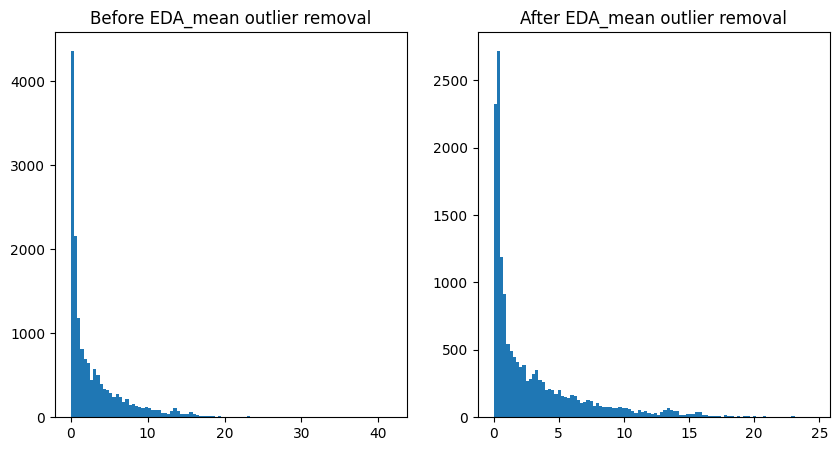

In [ ]:
eda_mean = outlier_removal(df_notnull, 'EDA_mean', 5)
print(eda_mean.shape)
compare_outlier_graph(df_notnull, eda_mean, 'EDA_mean')

(15555, 33)


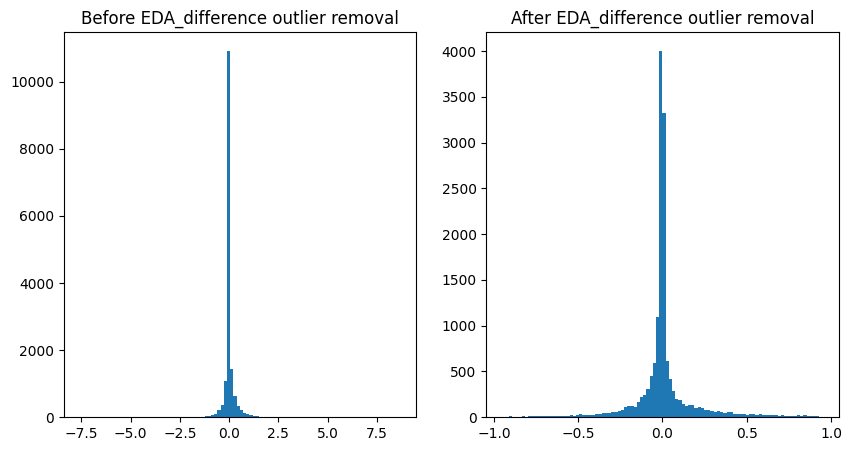

In [ ]:
eda_difference = outlier_removal(df_notnull, 'EDA_difference', 20)
print(eda_difference.shape)
compare_outlier_graph(df_notnull, eda_difference, 'EDA_difference')

(15877, 33)


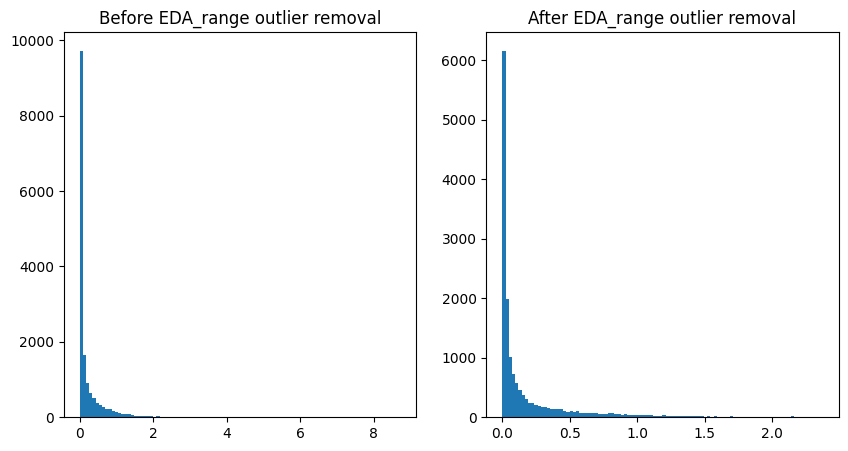

In [ ]:
eda_range = outlier_removal(df_notnull, 'EDA_range', 10)
print(eda_range.shape)
compare_outlier_graph(df_notnull, eda_range, 'EDA_range')

TEMP

(15964, 33)


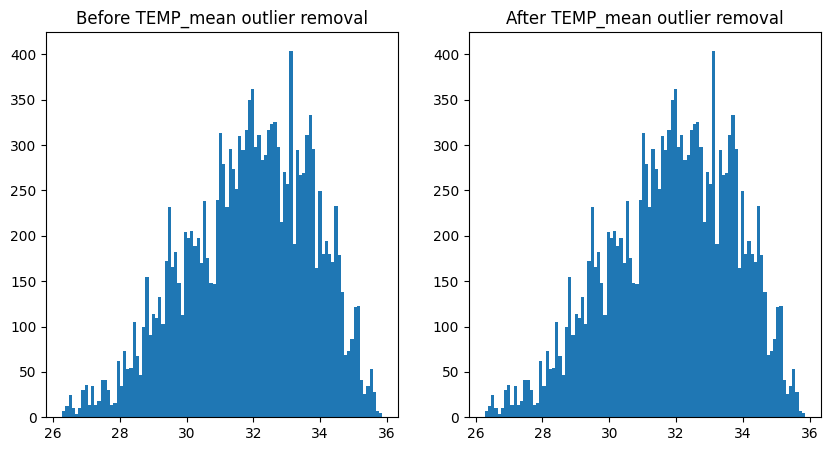

In [ ]:
temp_mean = outlier_removal(df_notnull, 'TEMP_mean', 3)
print(temp_mean.shape)
compare_outlier_graph(df_notnull, temp_mean, 'TEMP_mean')

(15874, 33)


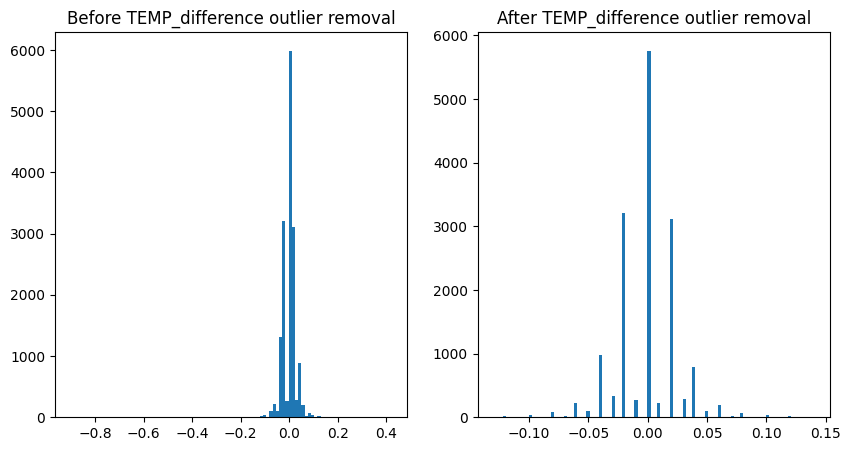

In [ ]:
temp_difference = outlier_removal(df_notnull, 'TEMP_difference', 3)
print(temp_difference.shape)
compare_outlier_graph(df_notnull, temp_difference, 'TEMP_difference')

(15824, 33)


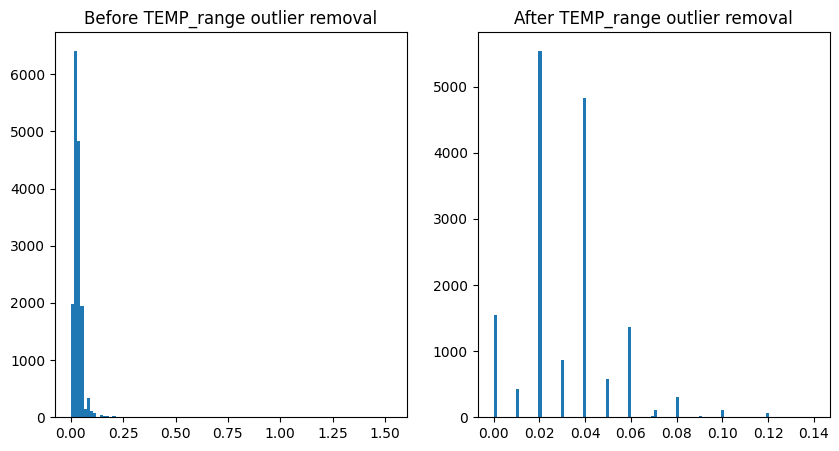

In [ ]:
temp_range = outlier_removal(df_notnull, 'TEMP_range', 5)
print(temp_range.shape)
compare_outlier_graph(df_notnull, temp_range, 'TEMP_range')

Data Join

In [ ]:
df_list = [ibi_mean, ibi_difference, ibi_range, eda_mean, eda_difference, eda_range, temp_mean, temp_difference, temp_range]

In [ ]:
from functools import reduce

intersection = reduce(lambda left, right: pd.merge(left, right, how='inner'), df_list)

In [ ]:
intersection.reset_index(inplace=True, drop=True)

In [ ]:
intersection

,Wav_start,Wav_end,Speaker,Emotion,Valence,Arousal,IBI_mean,IBI_count,IBI_std,IBI_max,...,TEMP_max,TEMP_min,TEMP_range,TEMP_difference,Emotion_p_i,Fleiss_Kappa,Session,Wav_length,Year,Position
0,15.47600,19.786,Sess01_script01_F001,fear,1.5,3.6,0.940800,5.0,0.022163,0.960000,...,30.71,30.69,0.02,0.02,0.488889,0.194631,Session01_F_res,4.31000,19,Speaker
1,28.94300,32.167,Sess01_script01_F002,fear,1.6,3.7,0.916000,3.0,0.024331,0.944000,...,30.71,30.69,0.02,0.02,0.644444,0.198791,Session01_F_res,3.22400,19,Speaker
2,39.26400,46.833,Sess01_script01_F003,fear,1.4,4.1,0.828889,9.0,0.026816,0.868000,...,30.75,30.69,0.06,0.04,0.355556,0.198791,Session01_F_res,7.56900,19,Speaker
3,73.01600,83.209,Sess01_script01_F005,fear,1.5,3.5,0.804923,13.0,0.054262,0.872000,...,30.73,30.71,0.02,0.02,0.533333,0.070443,Session01_F_res,10.19300,19,Speaker
4,97.48300,105.530,Sess01_script01_F006,fear,1.4,4.0,0.813778,9.0,0.024748,0.848000,...,30.77,30.71,0.06,0.02,0.488889,0.218391,Session01_F_res,8.04700,19,Speaker
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15293,289.44998,294.943,Sess40_script06_User079F_043,neutral,3.0,3.5,0.801339,7.0,0.032167,0.843750,...,35.07,35.05,0.02,-0.02,1.000000,0.259259,Sess40_eval,5.49302,20,Speaker
15294,294.94300,297.598,Sess40_script06_User079F_044,neutral,2.9,3.1,0.760417,3.0,0.018042,0.781250,...,35.07,35.05,0.02,0.02,1.000000,-0.045752,Sess40_eval,2.65500,20,Speaker
15295,297.59800,304.171,Sess40_script06_User079F_045,neutral,2.6,3.6,0.789931,9.0,0.036736,0.828125,...,35.07,35.05,0.02,0.00,0.800000,0.139785,Sess40_eval,6.57300,20,Speaker
15296,304.17100,306.863,Sess40_script06_User079F_046,neutral,2.7,3.3,0.755208,3.0,0.009021,0.765625,...,35.07,35.05,0.02,0.02,0.622222,-0.003584,Sess40_eval,2.69200,20,Speaker



### K-Fold

In [ ]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, random_state=2023)

data_index = []

for train_index, test_index in skf.split(intersection, intersection['Emotion']):
  data_index.append(test_index)

In [ ]:
data_index

[array([   0,    1,    2, ..., 4662, 4663, 4664]),
 array([1065, 1067, 1068, ..., 8471, 8472, 8473]),
 array([ 2364,  2366,  2367, ..., 10891, 10892, 10893]),
 array([ 3889,  3891,  4003, ..., 13149, 13150, 13152]),
 array([ 5819,  5820,  5821, ..., 15295, 15296, 15297])]

In [ ]:
df_subset = []

for index in data_index:
  subset = intersection.loc[index]
  df_subset.append(subset)

In [ ]:
for idx, df in enumerate(df_subset):
  df.to_csv(f'../../dataset/KFold/Subset{idx+1}.csv')